## Table of Contents

1. [Import Libraries](#Import-Libraries)
2. [Load Dataset](#Load-Dataset)
3. [Data Preprocessing](#Data-Preprocessing)
    1. [Replace Null Values](#Replace-Null-Values)
    2. [Remove Outliers](#Remove-Outliers)
    3. [Remove Unused Columns](#Remove-Unused-Columns)
    4. [Outliers Analysis after Unused Columnes Removal](#Outliers-Analysis-after-Unused-Columnes-Removal)
    5. [PCA](#PCA)
4. [Analysis](#Analysis)
    1. [GLM (Logistic Regression)](#GLM-(Logistic-Regression))
    2. [KNN](#KNN-(K-Nearest-Neighbor))
    3. [SVM](#SVM-(Support-Vector-Machines))
    4. [Random Forest](#Random-Forest)
    5. [Neural Network](#Neural-Network)
5. [Conclusion](#Conclusion)

## Import Libraries

In [282]:
#Importing the required libraries
import pandas as pd
import numpy as np
import re
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
import scipy.stats
from scipy.stats import chi2
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

Back to [ToC](#Table-of-Contents)

## Load Dataset

In [283]:
file_name = 'CS_data.txt'

# Read the text file into a pandas DataFrame
df = pd.read_csv(file_name,delimiter='\t',low_memory=False)

df.head(2)

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD.1
1,1,C,-99999,0,0,1,F,6,1,NaN,...,0,0,0,0,1,N,32,595,595,1
2,2,C,-99999,Web,0,1,F,2,0,NaN,...,0,0,0,0,1,N,34,230,230,1


Back to [ToC](#Table-of-Contents)

## Data Preprocessing

### Replace Null Values

In [284]:
# APPLICATION_SUBMISSION_TYPE
# Replace 0 value with either Web or Carga
df = df.replace({'APPLICATION_SUBMISSION_TYPE': {'0': None}})
df['APPLICATION_SUBMISSION_TYPE'] = df['APPLICATION_SUBMISSION_TYPE'].fillna(method='ffill')

# NATIONALITY
# Replace non 0 or 1 value with 0
df.loc[df.NATIONALITY != 1, 'NATIONALITY'] = 0

# INCOME
# Adding PERSONAL_MONTHLY_INCOME and OTHER_INCOMES
df['TOTAL_INCOME'] = df['PERSONAL_MONTHLY_INCOME'] + df['OTHER_INCOMES']

# CREDIT CARD OWNERSHIP
# CREDIT_CARD_HOLDER = 1 for rows where at least one of the specified flags 
# (FLAG_VISA, FLAG_MASTERCARD, etc.) is 1, 0 otherwise.
df['NUMBER_OF_CREDIT_CARDS'] = df.apply(lambda row: (0 if row['FLAG_VISA'] == 0 else 1) + 
                                        (0 if row['FLAG_MASTERCARD'] == 0 else 1) + 
                                        (0 if row['FLAG_DINERS'] == 0 else 1) +
                                        (0 if row['FLAG_AMERICAN_EXPRESS'] == 0 else 1) +
                                        (0 if row['FLAG_OTHER_CARDS'] == 0 else 1), axis=1)

# MONTHS_IN_RESIDENCE
# Replace null value with mode (most frequent value)
df['MONTHS_IN_RESIDENCE'].fillna(df['MONTHS_IN_RESIDENCE'].mode()[0],inplace=True)

# RESIDENCE_TYPE
# Replace null value with mode (most frequent value)
residence_type_mode = df['RESIDENCE_TYPE'].mode()
df = df.replace({'RESIDENCE_TYPE': {0: residence_type_mode}})
df = df.replace({'RESIDENCE_TYPE': {1: 'Owned by a resident - already paid', 
                                    2: 'Rented',
                                    3: 'Another condition',
                                    4: 'Owned by some residents - still paying',
                                    5: 'Assigned'}})

### Remove Outliers

In [285]:
# PAYMENT_DAY
# Delete rows from DataFrame where column PAYMENT_DAY is equal to -99999 
df = df[df['PAYMENT_DAY'] != -99999]

# AGE
# Filter out rows with age < 18
df = df[df['AGE'] >= 18]

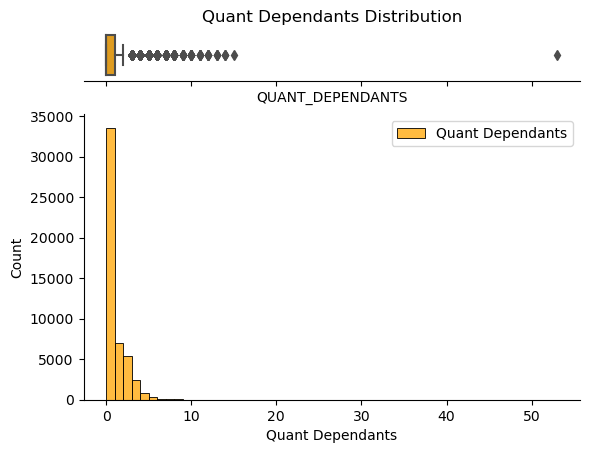

In [286]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=df['QUANT_DEPENDANTS'], ax=ax_box, color='orange')
ax_box.set_title('Quant Dependants Distribution')
sns.histplot(df['QUANT_DEPENDANTS'], color='orange', binwidth=1, label='Quant Dependants', ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.xlabel('Quant Dependants')
plt.ylabel('Count')
plt.legend()

plt.show()

In [287]:
# QUANT_DEPENDANTS
# Filter out rows with QUANT_DEPENDANTS > 20
df = df[df['QUANT_DEPENDANTS'] <= 20]

In [288]:
# Outlier Analysis
num_data = df.select_dtypes(['int64','float64'])
num_data.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,NATIONALITY,RESIDENCIAL_PHONE_AREA_CODE,MONTHS_IN_RESIDENCE,...,EDUCATION_LEVEL.1,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,AGE,TARGET_LABEL_BAD.1,TOTAL_INCOME,NUMBER_OF_CREDIT_CARDS
count,49888.000000,49888.000000,49888.0,49888.000000,49888.000000,49888.000000,824.000000,49888.000000,41690.000000,49888.000000,...,17633.000000,49888.0,49888.0,49888.0,49888.0,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000
mean,25045.946580,12.870269,0.0,1.006555,2.148733,0.649675,1.720874,0.957605,64.536963,9.072743,...,0.295696,0.0,0.0,0.0,0.0,1.275337,43.260243,0.260844,922.561541,0.214160
std,14407.283645,6.608218,0.0,0.080696,1.322771,1.170874,0.448842,0.201491,38.511161,10.519145,...,0.955398,0.0,0.0,0.0,0.0,0.987260,14.981726,0.439100,7906.274452,0.523046
min,91.000000,1.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,18.000000,0.000000,60.000000,0.000000
25%,12569.750000,10.000000,0.0,1.000000,1.000000,0.000000,1.000000,1.000000,29.000000,1.000000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,31.000000,0.000000,372.000000,0.000000
50%,25047.500000,10.000000,0.0,1.000000,2.000000,0.000000,2.000000,1.000000,68.000000,5.000000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,41.000000,0.000000,515.000000,0.000000
75%,37521.250000,15.000000,0.0,1.000000,2.000000,1.000000,2.000000,1.000000,100.000000,14.000000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,54.000000,1.000000,839.250000,0.000000
max,50000.000000,25.000000,0.0,2.000000,7.000000,15.000000,2.000000,1.000000,126.000000,228.000000,...,5.000000,0.0,0.0,0.0,0.0,7.000000,106.000000,1.000000,959000.000000,4.000000


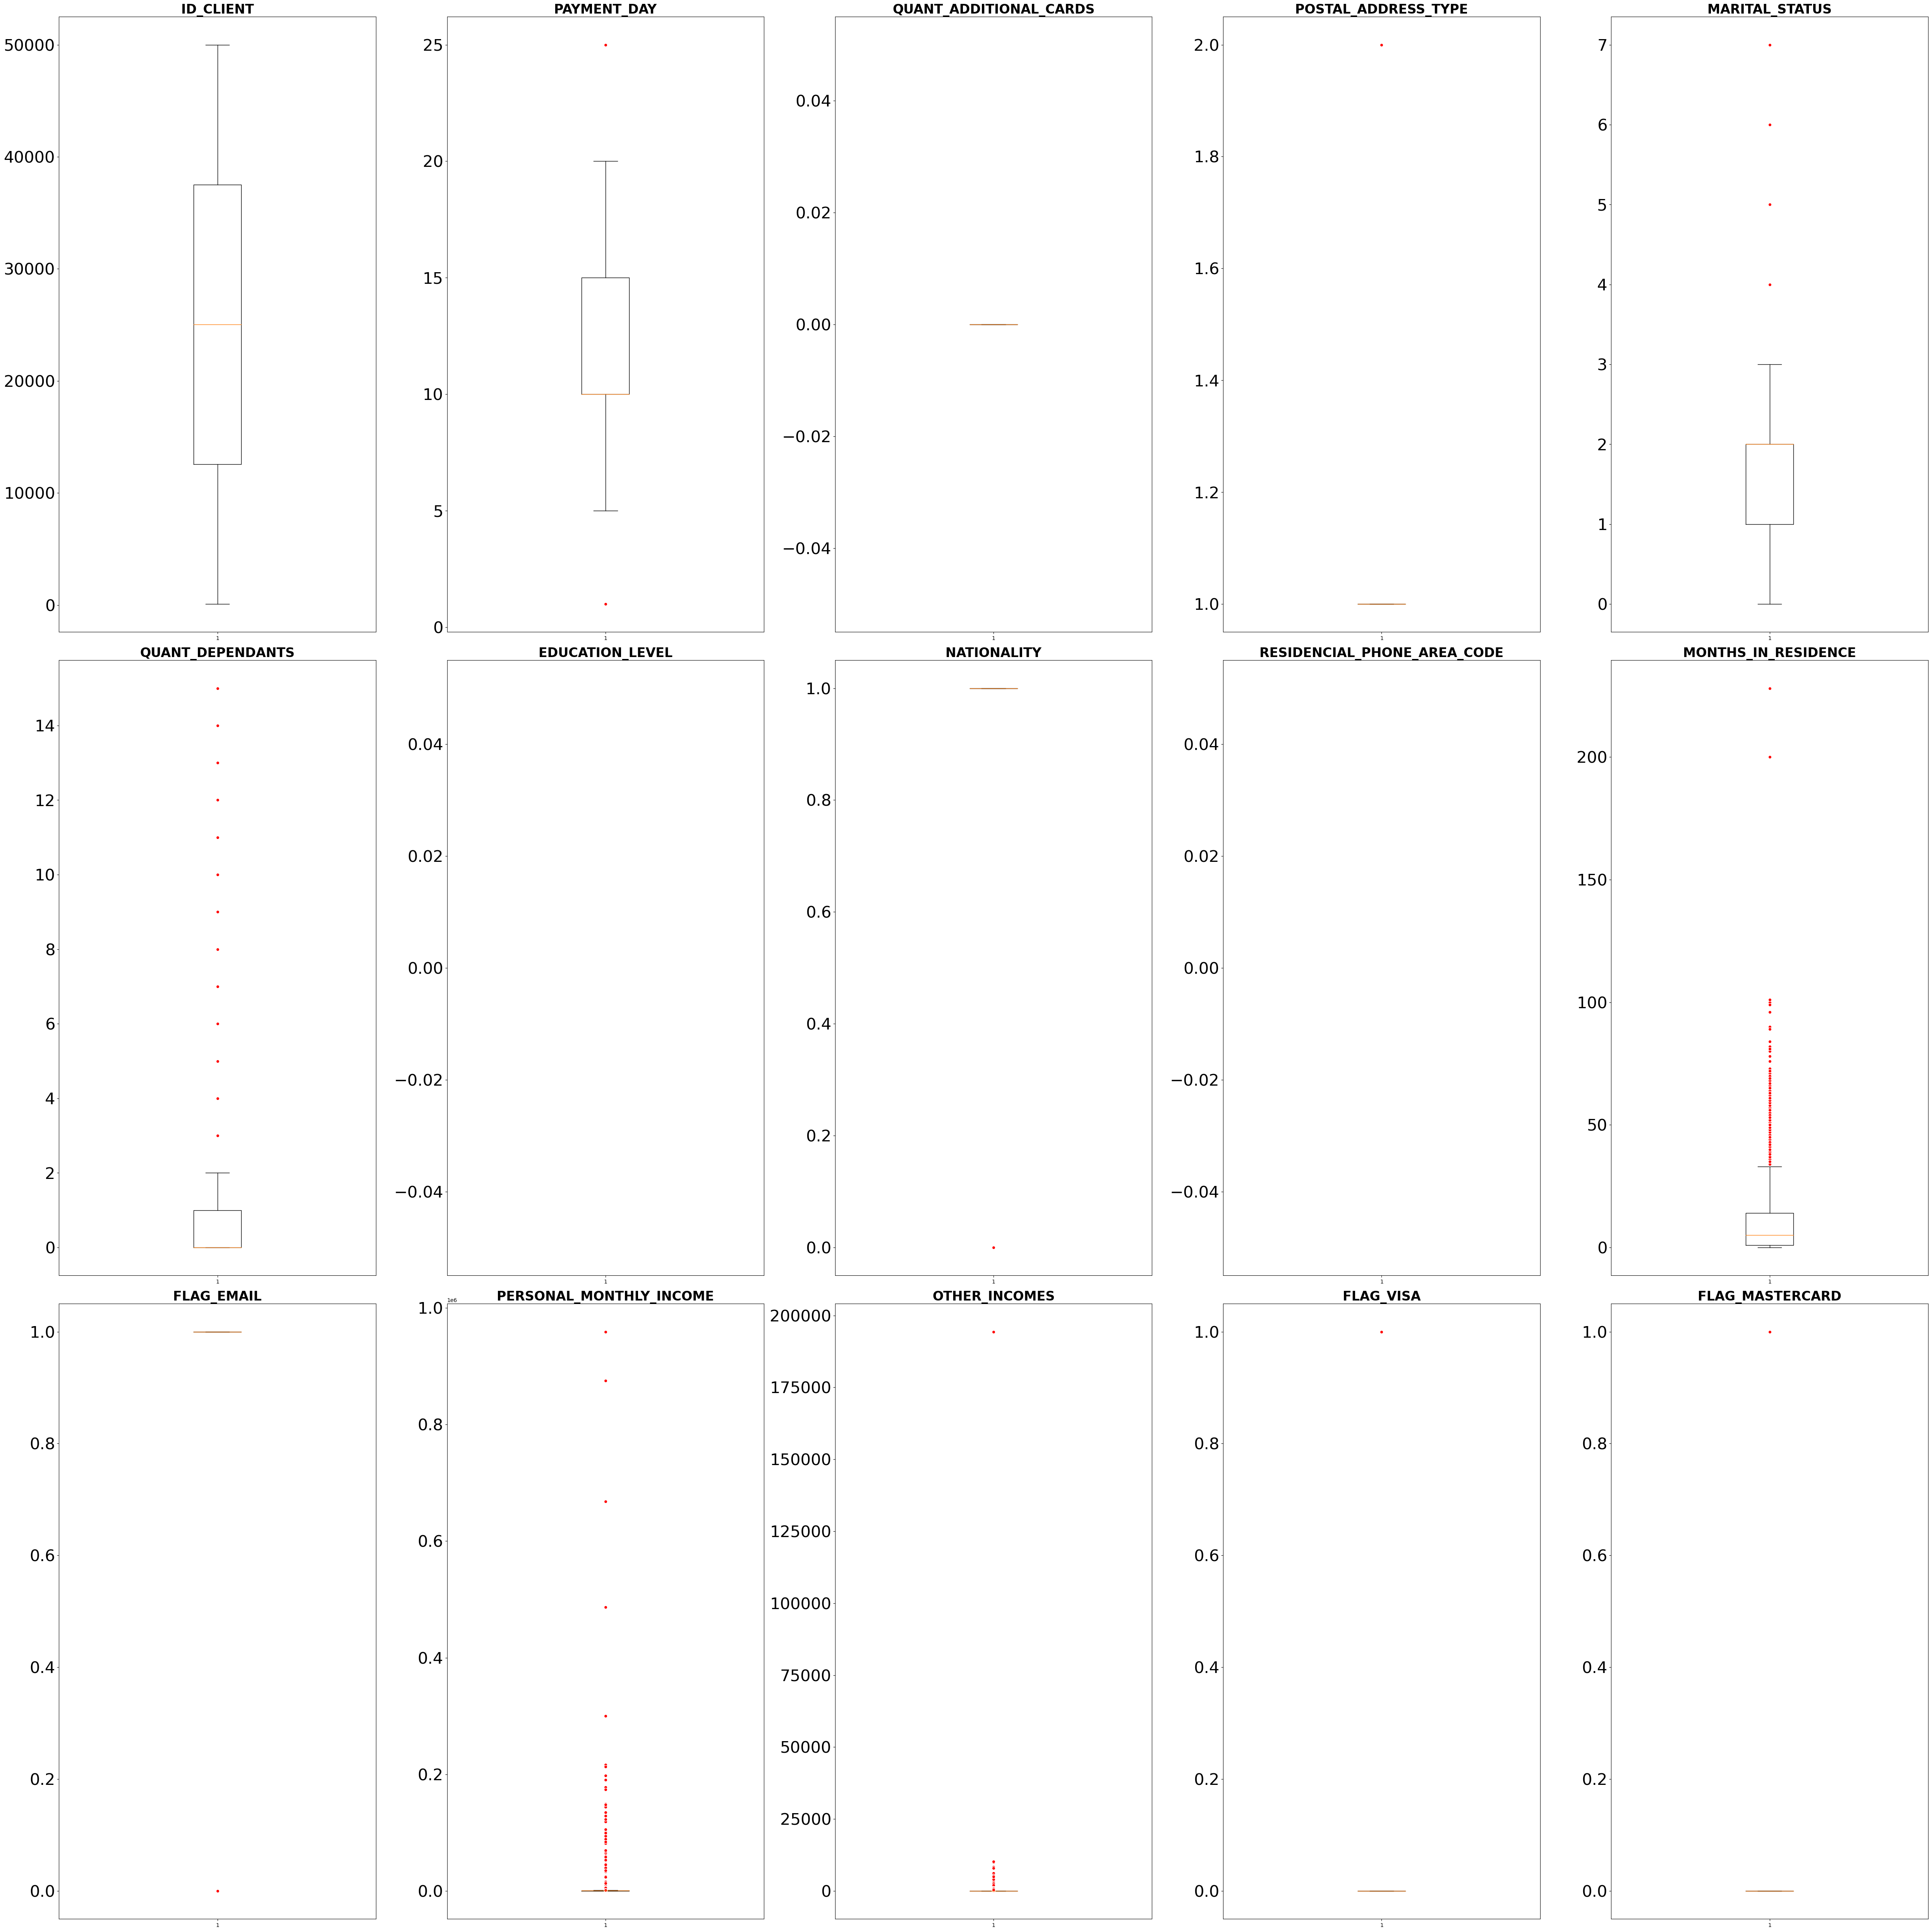

In [289]:
fig, axs = plt.subplots(3,5, figsize=(50,50))
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

for i, ax in enumerate(axs.flat):
    # Check if the index exceeds the number of columns in num_data
    if i < num_data.shape[1]:
        ax.boxplot(num_data.iloc[:, i], flierprops=red_circle)
        ax.set_title(num_data.columns[i], fontsize=24, fontweight='bold')
        ax.tick_params(axis='y', labelsize=30)
    else:
        # If there are fewer columns than subplots, remove the empty subplots
        fig.delaxes(ax)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()

# Display the plots
plt.show()

Back to [ToC](#Table-of-Contents)

### Remove Unused Columns

In [290]:
#List of columns to delete as they are not required in data modelling
columns_to_delete= ['CLERK_TYPE',
                    'EDUCATION_LEVEL.1',
                    'MONTHS_IN_THE_JOB',
                    'QUANT_ADDITIONAL_CARDS',
                    'POSTAL_ADDRESS_TYPE',
                    'MARITAL_STATUS',
                    'EDUCATION_LEVEL',
                    'STATE_OF_BIRTH',
                    'CITY_OF_BIRTH',
                    'RESIDENCIAL_STATE',
                    'RESIDENCIAL_CITY',
                    'RESIDENCIAL_BOROUGH',
                    'FLAG_RESIDENCIAL_PHONE',
                    'RESIDENCIAL_PHONE_AREA_CODE',
                    'FLAG_MOBILE_PHONE',
                    'FLAG_EMAIL',
                    'FLAG_VISA',
                    'FLAG_MASTERCARD',
                    'FLAG_DINERS',
                    'FLAG_AMERICAN_EXPRESS',
                    'FLAG_OTHER_CARDS',
                    'QUANT_SPECIAL_BANKING_ACCOUNTS',
                    'PERSONAL_ASSETS_VALUE',
                    'COMPANY',
                    'PROFESSIONAL_STATE',
                    'PROFESSIONAL_CITY',
                    'PROFESSIONAL_BOROUGH',
                    'FLAG_PROFESSIONAL_PHONE',
                    'PROFESSIONAL_PHONE_AREA_CODE',
                    'PROFESSION_CODE',
                    'OCCUPATION_TYPE',
                    'MATE_PROFESSION_CODE',
                    'EDUCATION_LEVEL',
                    'FLAG_HOME_ADDRESS_DOCUMENT',
                    'FLAG_RG',
                    'FLAG_CPF',
                    'FLAG_INCOME_PROOF',
                    'RESIDENCIAL_ZIP_3',
                    'PROFESSIONAL_ZIP_3',
                    'FLAG_ACSP_RECORD',
                    'PERSONAL_MONTHLY_INCOME',
                    'QUANT_BANKING_ACCOUNTS',
                    'OTHER_INCOMES',
                    'SEX']
df = df.drop(columns = columns_to_delete)
df.head(2)

,ID_CLIENT,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_DEPENDANTS,NATIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,QUANT_CARS,PRODUCT,AGE,TARGET_LABEL_BAD.1,TOTAL_INCOME,NUMBER_OF_CREDIT_CARDS
91,91,10,Carga,0,1,Owned by a resident - already paid,1.0,0,1,63,0,351.0,0
92,92,25,Web,0,1,Owned by a resident - already paid,1.0,0,1,25,0,394.0,0


In [291]:
df.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_DEPENDANTS,NATIONALITY,MONTHS_IN_RESIDENCE,QUANT_CARS,PRODUCT,AGE,TARGET_LABEL_BAD.1,TOTAL_INCOME,NUMBER_OF_CREDIT_CARDS
count,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000
mean,25045.946580,12.870269,0.649675,0.957605,9.072743,0.336373,1.275337,43.260243,0.260844,922.561541,0.214160
std,14407.283645,6.608218,1.170874,0.201491,10.519145,0.472473,0.987260,14.981726,0.439100,7906.274452,0.523046
min,91.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,0.000000,60.000000,0.000000
25%,12569.750000,10.000000,0.000000,1.000000,1.000000,0.000000,1.000000,31.000000,0.000000,372.000000,0.000000
50%,25047.500000,10.000000,0.000000,1.000000,5.000000,0.000000,1.000000,41.000000,0.000000,515.000000,0.000000
75%,37521.250000,15.000000,1.000000,1.000000,14.000000,1.000000,1.000000,54.000000,1.000000,839.250000,0.000000
max,50000.000000,25.000000,15.000000,1.000000,228.000000,1.000000,7.000000,106.000000,1.000000,959000.000000,4.000000


In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49888 entries, 91 to 50000
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_CLIENT                    49888 non-null  int64  
 1   PAYMENT_DAY                  49888 non-null  int64  
 2   APPLICATION_SUBMISSION_TYPE  49888 non-null  object 
 3   QUANT_DEPENDANTS             49888 non-null  int64  
 4   NATIONALITY                  49888 non-null  int64  
 5   RESIDENCE_TYPE               48541 non-null  object 
 6   MONTHS_IN_RESIDENCE          49888 non-null  float64
 7   QUANT_CARS                   49888 non-null  int64  
 8   PRODUCT                      49888 non-null  int64  
 9   AGE                          49888 non-null  int64  
 10  TARGET_LABEL_BAD.1           49888 non-null  int64  
 11  TOTAL_INCOME                 49888 non-null  float64
 12  NUMBER_OF_CREDIT_CARDS       49888 non-null  int64  
dtypes: float64(2), 

Back to [ToC](#Table-of-Contents)

### Outliers Analysis after Unused Columns Removal

In [293]:
num_data = df.select_dtypes(['int64','float64'])
num_data.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_DEPENDANTS,NATIONALITY,MONTHS_IN_RESIDENCE,QUANT_CARS,PRODUCT,AGE,TARGET_LABEL_BAD.1,TOTAL_INCOME,NUMBER_OF_CREDIT_CARDS
count,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000
mean,25045.946580,12.870269,0.649675,0.957605,9.072743,0.336373,1.275337,43.260243,0.260844,922.561541,0.214160
std,14407.283645,6.608218,1.170874,0.201491,10.519145,0.472473,0.987260,14.981726,0.439100,7906.274452,0.523046
min,91.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,0.000000,60.000000,0.000000
25%,12569.750000,10.000000,0.000000,1.000000,1.000000,0.000000,1.000000,31.000000,0.000000,372.000000,0.000000
50%,25047.500000,10.000000,0.000000,1.000000,5.000000,0.000000,1.000000,41.000000,0.000000,515.000000,0.000000
75%,37521.250000,15.000000,1.000000,1.000000,14.000000,1.000000,1.000000,54.000000,1.000000,839.250000,0.000000
max,50000.000000,25.000000,15.000000,1.000000,228.000000,1.000000,7.000000,106.000000,1.000000,959000.000000,4.000000


In [294]:
num_data.columns

Index(['ID_CLIENT', 'PAYMENT_DAY', 'QUANT_DEPENDANTS', 'NATIONALITY',
       'MONTHS_IN_RESIDENCE', 'QUANT_CARS', 'PRODUCT', 'AGE',
       'TARGET_LABEL_BAD.1', 'TOTAL_INCOME', 'NUMBER_OF_CREDIT_CARDS'],
      dtype='object')

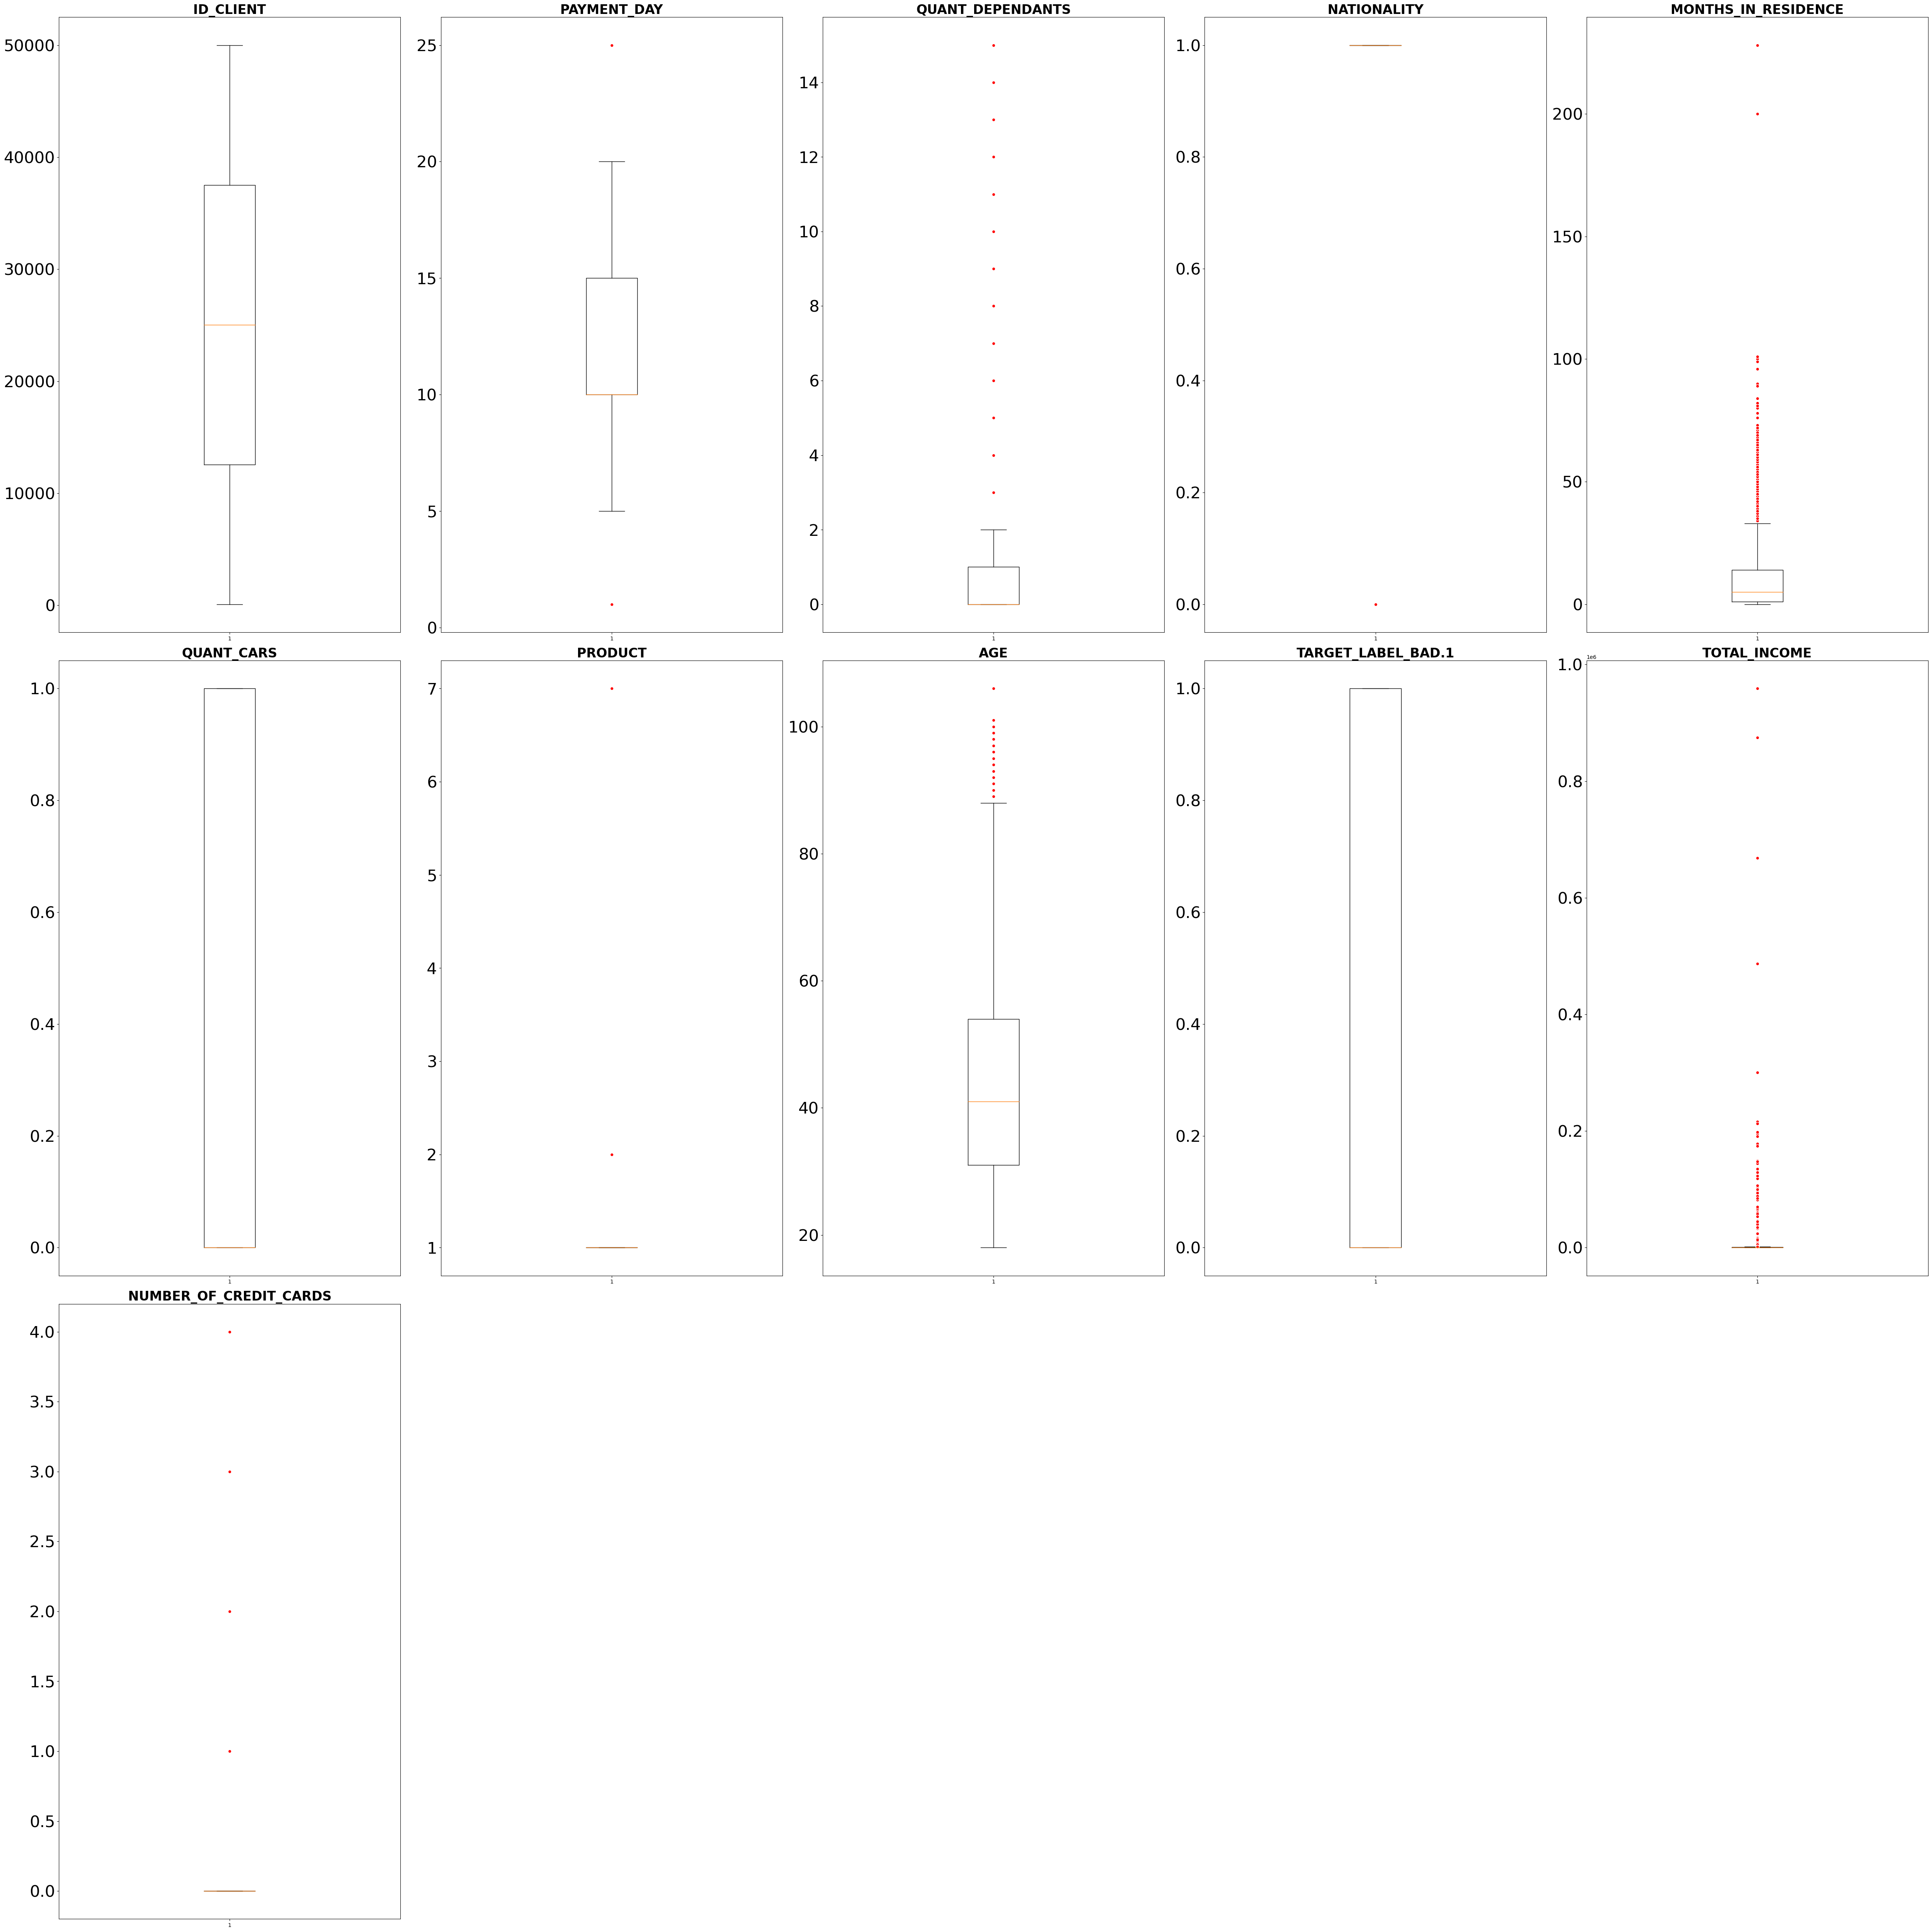

In [295]:
fig, axs = plt.subplots(3,5, figsize=(50,50))
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

for i, ax in enumerate(axs.flat):
    # Check if the index exceeds the number of columns in num_data
    if i < num_data.shape[1]:
        ax.boxplot(num_data.iloc[:, i], flierprops=red_circle)
        ax.set_title(num_data.columns[i], fontsize=24, fontweight='bold')
        ax.tick_params(axis='y', labelsize=30)
    else:
        # If there are fewer columns than subplots, remove the empty subplots
        fig.delaxes(ax)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()

# Display the plots
plt.show()

In [296]:
num_data.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_DEPENDANTS,NATIONALITY,MONTHS_IN_RESIDENCE,QUANT_CARS,PRODUCT,AGE,TARGET_LABEL_BAD.1,TOTAL_INCOME,NUMBER_OF_CREDIT_CARDS
count,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000,49888.000000
mean,25045.946580,12.870269,0.649675,0.957605,9.072743,0.336373,1.275337,43.260243,0.260844,922.561541,0.214160
std,14407.283645,6.608218,1.170874,0.201491,10.519145,0.472473,0.987260,14.981726,0.439100,7906.274452,0.523046
min,91.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,0.000000,60.000000,0.000000
25%,12569.750000,10.000000,0.000000,1.000000,1.000000,0.000000,1.000000,31.000000,0.000000,372.000000,0.000000
50%,25047.500000,10.000000,0.000000,1.000000,5.000000,0.000000,1.000000,41.000000,0.000000,515.000000,0.000000
75%,37521.250000,15.000000,1.000000,1.000000,14.000000,1.000000,1.000000,54.000000,1.000000,839.250000,0.000000
max,50000.000000,25.000000,15.000000,1.000000,228.000000,1.000000,7.000000,106.000000,1.000000,959000.000000,4.000000


Back to [ToC](#Table-of-Contents)

### Logistic Regression

#### SMOTE

In [358]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import numpy as np

# Convert object variables to dummy variables
df_dummies = pd.get_dummies(df, columns=df.select_dtypes(include='object').columns)

# Drop specified columns
columns_to_drop = ['RESIDENCE_TYPE_Another condition', 'APPLICATION_SUBMISSION_TYPE_Carga', 'ID_CLIENT']
df_dummies = df_dummies.drop(columns=columns_to_drop, errors='ignore')

# Split data into features (X) and target variable (y)
X = df_dummies.drop(columns=['TARGET_LABEL_BAD.1'])
y = df_dummies['TARGET_LABEL_BAD.1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_smote_y_test = y_test
# Use SMOTE to balance the data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Fit logistic regression model
logit_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled))
result = logit_model.fit()

# Display results with statistical significance
results_df = pd.DataFrame({
    'Variable': ['const'] + X.columns.tolist(),
    'Coefficient': result.params.values,
    'Odds Ratio': np.exp(result.params.values),
    'p>|z|': result.pvalues.values
})

# Drop rows corresponding to dropped columns
results_df = results_df[~results_df['Variable'].isin(columns_to_drop)]

print(results_df)

# Make predictions on the test set
lr_smote_probabilities = result.predict(sm.add_constant(X_test))
y_pred = (lr_smote_probabilities > 0.5).astype(int)
lr_smote_pred = y_pred
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, lr_smote_probabilities)

# Additional Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUC: {auc:.2f}")
print(f"Precision (1): {precision:.2f}")
print(f"Recall (1): {recall:.2f}")
print(f"F1 Score (1): {f1:.2f}")

Optimization terminated successfully.
         Current function value: 0.631248
         Iterations 6
                                             Variable  Coefficient  \
0                                               const     3.371399   
1                                         PAYMENT_DAY     0.016437   
2                                    QUANT_DEPENDANTS    -0.093022   
3                                         NATIONALITY    -0.683348   
4                                 MONTHS_IN_RESIDENCE     0.005527   
5                                          QUANT_CARS    -0.528118   
6                                             PRODUCT    -0.061137   
7                                                 AGE    -0.016065   
8                                        TOTAL_INCOME     0.000002   
9                              NUMBER_OF_CREDIT_CARDS    -0.441446   
10                    APPLICATION_SUBMISSION_TYPE_Web    -0.439623   
11                            RESIDENCE_TYPE_Assigned    -

#### SMOTEENN

In [408]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import numpy as np

# # Split data into features (X) and target variable (y)
# X = df_dummies.drop(columns=['TARGET_LABEL_BAD.1'])
# y = df_dummies['TARGET_LABEL_BAD.1']
columns=df.select_dtypes(include='object').columns
encoded_df = pd.get_dummies(df, columns=columns, drop_first=True)
X = encoded_df.drop(['TARGET_LABEL_BAD.1','ID_CLIENT'],axis=1)
y = encoded_df['TARGET_LABEL_BAD.1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Use SMOTE-ENN to balance the data
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Fit logistic regression model
logit_model = sm.Logit(y_train_resampled, sm.add_constant(X_train_resampled))
result = logit_model.fit()

# Display results with statistical significance
results_df = pd.DataFrame({
    'Variable': ['const'] + X.columns.tolist(),
    'Coefficient': result.params.values,
    'Odds Ratio': np.exp(result.params.values),
    'p>|z|': result.pvalues.values
})

# Drop rows corresponding to dropped columns
results_df = results_df[~results_df['Variable'].isin(columns_to_drop)]

print(results_df)

# Make predictions on the test set
lr_smoteenn_probabilities = result.predict(sm.add_constant(X_test))
y_pred = (lr_smoteenn_probabilities > 0.5).astype(int)
lr_smoteenn_pred = y_pred
lr_smoteenn_y_test = y_test
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, lr_smoteenn_probabilities)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUC: {auc:.2f}")
print(f"Precision (1): {precision:.2f}")
print(f"Recall (1): {recall:.2f}")
print(f"F1 Score (1): {f1:.2f}")

Optimization terminated successfully.
         Current function value: 0.575010
         Iterations 6
                                             Variable  Coefficient  \
0                                               const     4.393901   
1                                         PAYMENT_DAY     0.034584   
2                                    QUANT_DEPENDANTS    -0.082793   
3                                         NATIONALITY    -0.527846   
4                                 MONTHS_IN_RESIDENCE     0.001623   
5                                          QUANT_CARS    -0.526231   
6                                             PRODUCT    -0.055565   
7                                                 AGE    -0.032490   
8                                        TOTAL_INCOME    -0.000007   
9                              NUMBER_OF_CREDIT_CARDS    -0.493146   
10                    APPLICATION_SUBMISSION_TYPE_Web    -0.524183   
11                            RESIDENCE_TYPE_Assigned    -

Back to [ToC](#Table-of-Contents)

### KNN (K-Nearest Neighbor)

In [299]:
X = df.drop(columns=['TARGET_LABEL_BAD.1'])
y = df['TARGET_LABEL_BAD.1'].values

In [300]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

le = LabelEncoder()
X['RESIDENCE_TYPE'] = le.fit_transform(X['RESIDENCE_TYPE'])

lb = LabelBinarizer()
X['APPLICATION_SUBMISSION_TYPE'] = lb.fit_transform(X['APPLICATION_SUBMISSION_TYPE'])
X['RESIDENCE_TYPE'] = lb.fit_transform(X['RESIDENCE_TYPE']) 
X['QUANT_CARS'] = lb.fit_transform(X['QUANT_CARS'])

#### Resampling of Training Data due to Imbalance in data using SMOTEENN

In [301]:
!pip install imbalanced-learn

In [366]:
# KNN Model Code

from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN  # Import SMOTEENN
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
knn_smoteenn_y_test = y_test
# Apply SMOTEENN for Oversampling and Undersampling
smoteenn = SMOTEENN(sampling_strategy='auto', random_state=42)

X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_knn_test = scaler.transform(X_test)

In [367]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# from numpy import ravel

# knn = KNeighborsClassifier()

# k_range = list(range(1, 20))
# param_grid = dict(n_neighbors = k_range)
  
# # defining parameter range
# grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
  
# # fitting the model for grid search
# grid_search=grid.fit(X_train_resampled, ravel(y_train_resampled))

In [368]:
# SOLUTION
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=18)

knn.fit(X_train_resampled, y_train_resampled)

y_test_smoteenn = knn.predict(X_knn_test)
knn_smoteenn_pred = y_test_smoteenn

In [305]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_smoteenn)

0.5053116857085588

In [306]:
from sklearn.metrics import classification_report, confusion_matrix
print('Accuracy:', accuracy_score(y_test,y_test_smoteenn))
print('AUC:',roc_auc_score(y_test,y_test_smoteenn))
print(classification_report(y_test, y_test_smoteenn))
print('confusion_matrix:\n',confusion_matrix(y_test, y_test_smoteenn))

Accuracy: 0.5053116857085588
AUC: 0.5209145752234223
              precision    recall  f1-score   support

           0       0.76      0.49      0.59     11063
           1       0.28      0.55      0.37      3904

    accuracy                           0.51     14967
   macro avg       0.52      0.52      0.48     14967
weighted avg       0.63      0.51      0.53     14967

confusion_matrix:
 [[5402 5661]
 [1743 2161]]


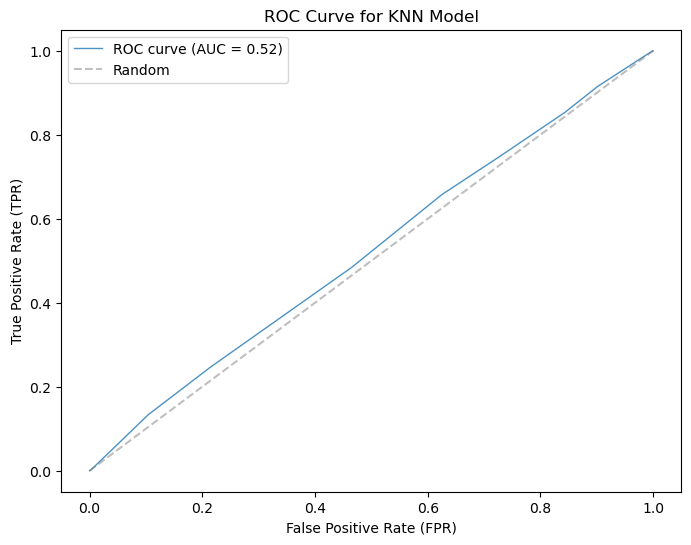

In [307]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming knn, X_test, and y_test are defined
# Replace X_test and y_test with your actual test data

# Get probability scores for the positive class
knn_smoteenn_probabilities = knn.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, knn_smoteenn_probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random', alpha=0.5)
plt.title('ROC Curve for KNN Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

Back to [ToC](#Table-of-Contents)

#### Over Sampling of Training Data due to Imbalance in data using SMOTE

In [308]:
!pip install imbalanced-learn

In [364]:
# KNN Model Code

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
knn_smote_y_test = y_test
from sklearn.preprocessing import StandardScaler

# Apply SMOTE for Oversampling
oversampler = SMOTE(sampling_strategy='auto', random_state=42) 

X_train_resampled2, y_train_resampled2 = oversampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_resampled2 = scaler.fit_transform(X_train_resampled2)
X_test = scaler.transform(X_test)

In [365]:
# SOLUTION

knn = KNeighborsClassifier(n_neighbors=14)

knn.fit(X_train_resampled2, y_train_resampled2)

prediction = knn.predict(X_test)
knn_smote_pred = prediction

In [329]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# from numpy import ravel

# knn = KNeighborsClassifier()

# k_range = list(range(1, 20))
# param_grid = dict(n_neighbors = k_range)
  
# # defining parameter range
# grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
  
# # fitting the model for grid search
# grid_search=grid.fit(X_train_resampled2, ravel(y_train_resampled2))

In [330]:
# print(grid_search.best_params_)

In [337]:
from sklearn.metrics import classification_report, confusion_matrix
print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print(classification_report(y_test, prediction))
print('confusion_matrix:\n',confusion_matrix(y_test, prediction))

Accuracy: 0.6355315026391395
AUC: 0.5158460352074482
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     11063
           1       0.29      0.27      0.28      3904

    accuracy                           0.64     14967
   macro avg       0.52      0.52      0.52     14967
weighted avg       0.63      0.64      0.63     14967

confusion_matrix:
 [[8475 2588]
 [2867 1037]]


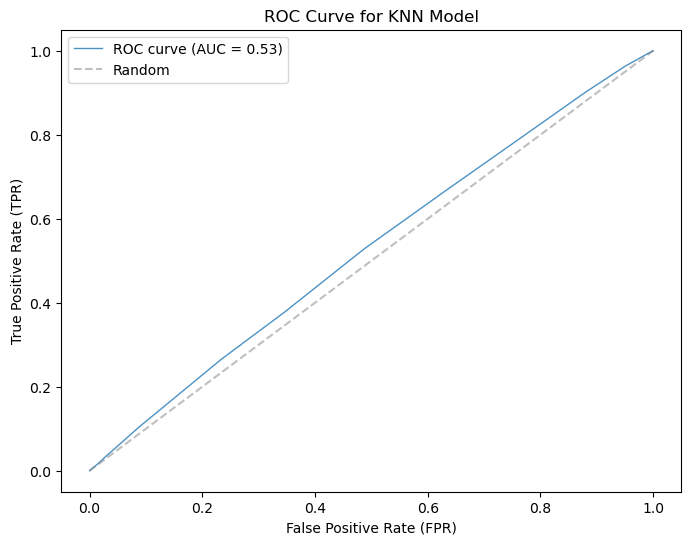

In [338]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming knn, X_test, and y_test are defined
# Replace X_test and y_test with your actual test data

# Get probability scores for the positive class
knn_smote_probabilities = knn.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, knn_smote_probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random', alpha=0.5)
plt.title('ROC Curve for KNN Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

Back to [ToC](#Table-of-Contents)

### Random Forest

#### SMOTE 

In [413]:

encoded_df = pd.get_dummies(df, columns=['APPLICATION_SUBMISSION_TYPE','RESIDENCE_TYPE'], drop_first=True)
X = encoded_df.drop(['TARGET_LABEL_BAD.1','ID_CLIENT'],axis=1)
y = encoded_df['TARGET_LABEL_BAD.1']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [414]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

smote = SMOTE(random_state=42)
X_s, y_s = smote.fit_resample(X_train, y_train)


rf_smote = RandomForestClassifier(n_estimators=100) 
rf_smote.fit(X_s, y_s.values.ravel())
prediction = rf_smote.predict(X_test)
rf_smote_pred = prediction
print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print(classification_report(y_test, prediction))
print('confusion_matrix:\n',confusion_matrix(y_test, prediction))

Accuracy: 0.6485601656978687
AUC: 0.5123932413724377
              precision    recall  f1-score   support

           0       0.75      0.80      0.77     11063
           1       0.28      0.23      0.25      3904

    accuracy                           0.65     14967
   macro avg       0.51      0.51      0.51     14967
weighted avg       0.62      0.65      0.64     14967

confusion_matrix:
 [[8818 2245]
 [3015  889]]


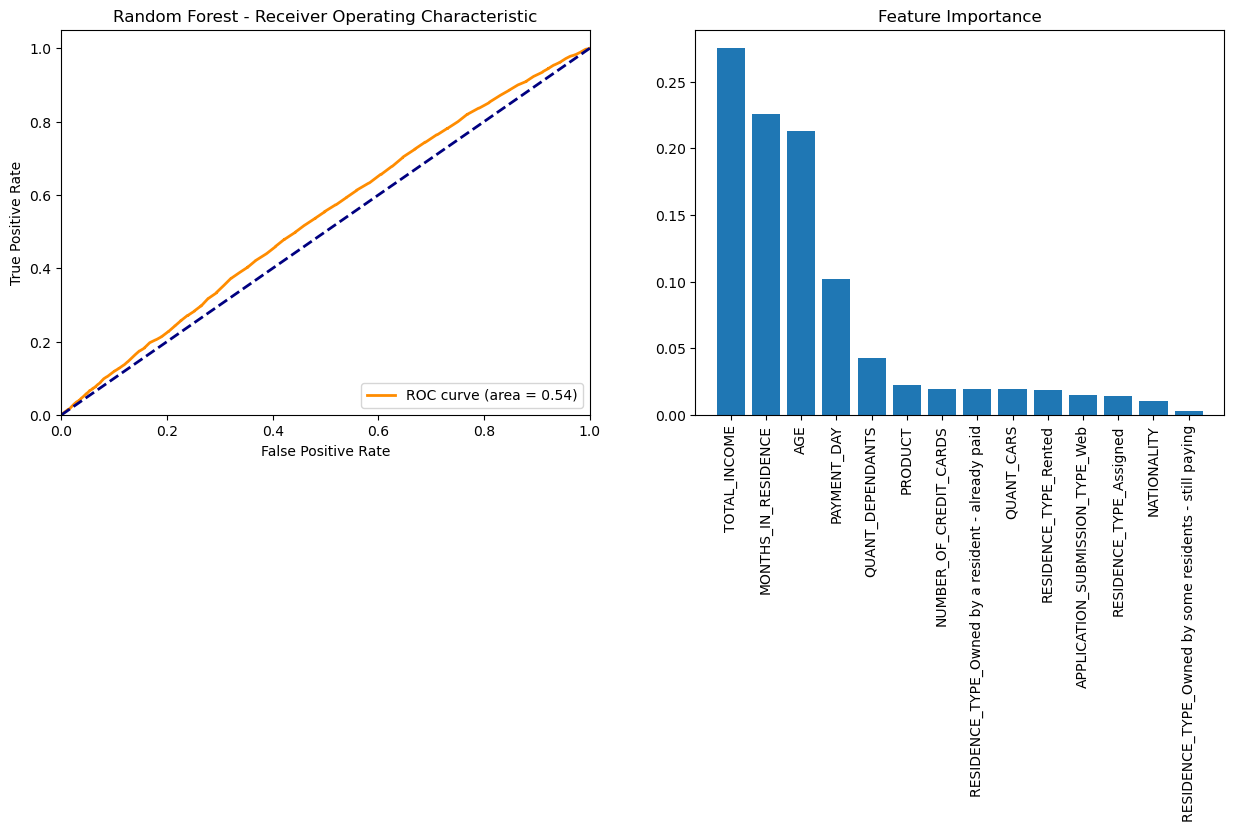

In [415]:
# generate data for ROC
from sklearn.metrics import roc_curve, auc
rf_smote_probabilities = rf_smote.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_smote_probabilities)
roc_auc = auc(fpr, tpr)
rf_smote_y_test = y_test
# generate data for Feature Importance
importances = rf_smote.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 5))  
# Plotting ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic')
plt.legend(loc="lower right")

# plot feature importance
plt.subplot(1, 2, 2)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### SMOTEENN

In [416]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_s, y_s = smote_enn.fit_resample(X_train, y_train)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
rf_smoteenn_y_test = y_test

rf_smoteenn = RandomForestClassifier(n_estimators=100) 
rf_smoteenn.fit(X_s,y_s.ravel())
prediction = rf_smoteenn.predict(X_test)
rf_smoteenn_pred = prediction
print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print(classification_report(y_test, prediction))
print('confusion_matrix:\n',confusion_matrix(y_test, prediction))

Accuracy: 0.572659851673682
AUC: 0.5349781703855564
              precision    recall  f1-score   support

           0       0.76      0.61      0.68     11063
           1       0.29      0.46      0.36      3904

    accuracy                           0.57     14967
   macro avg       0.53      0.53      0.52     14967
weighted avg       0.64      0.57      0.60     14967

confusion_matrix:
 [[6790 4273]
 [2123 1781]]


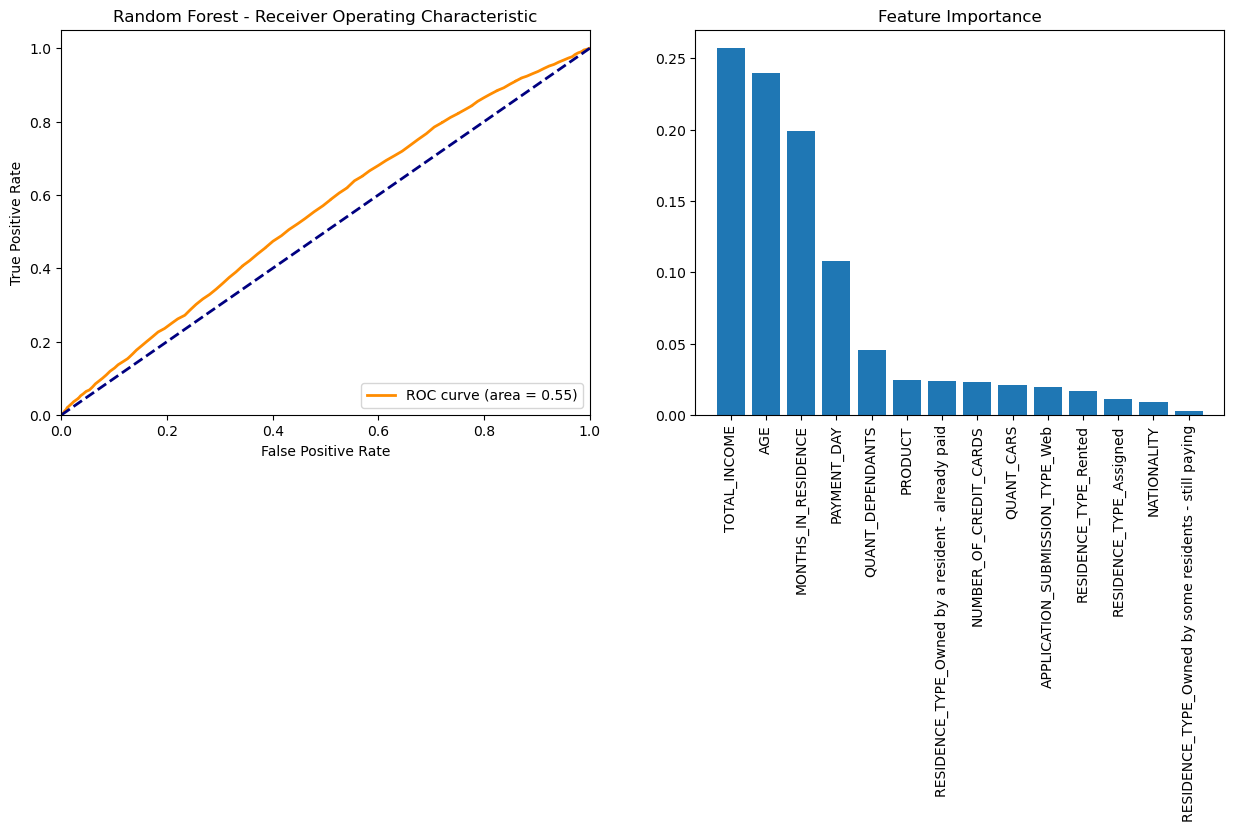

In [417]:
# generate data for ROC
rf_smoteenn_probabilities = rf_smoteenn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_smoteenn_probabilities)
roc_auc = auc(fpr, tpr)
rf_smoteenn_y_test = y_test
# generate data for Feature Importance
importances = rf_smoteenn.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 5))  
# Plotting ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic')
plt.legend(loc="lower right")

# plot feature importance
plt.subplot(1, 2, 2)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Back to [ToC](#Table-of-Contents)

### Adaboost

#### SMOTE

In [418]:
encoded_df = pd.get_dummies(df, columns=['APPLICATION_SUBMISSION_TYPE','RESIDENCE_TYPE'], drop_first=True)
X = encoded_df.drop(['TARGET_LABEL_BAD.1','ID_CLIENT'],axis=1)
y = encoded_df['TARGET_LABEL_BAD.1']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
boosting = AdaBoostClassifier(random_state=42)
boosting.fit(X_resampled, y_resampled)
prediction = boosting.predict(X_test)
adaboost_smote_pred = prediction
print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print(classification_report(y_test, prediction))
print('confusion_matrix:\n',confusion_matrix(y_test, prediction))

Accuracy: 0.611010890626044
AUC: 0.5293439548161573
              precision    recall  f1-score   support

           0       0.76      0.70      0.73     11063
           1       0.30      0.36      0.32      3904

    accuracy                           0.61     14967
   macro avg       0.53      0.53      0.53     14967
weighted avg       0.64      0.61      0.62     14967

confusion_matrix:
 [[7745 3318]
 [2504 1400]]


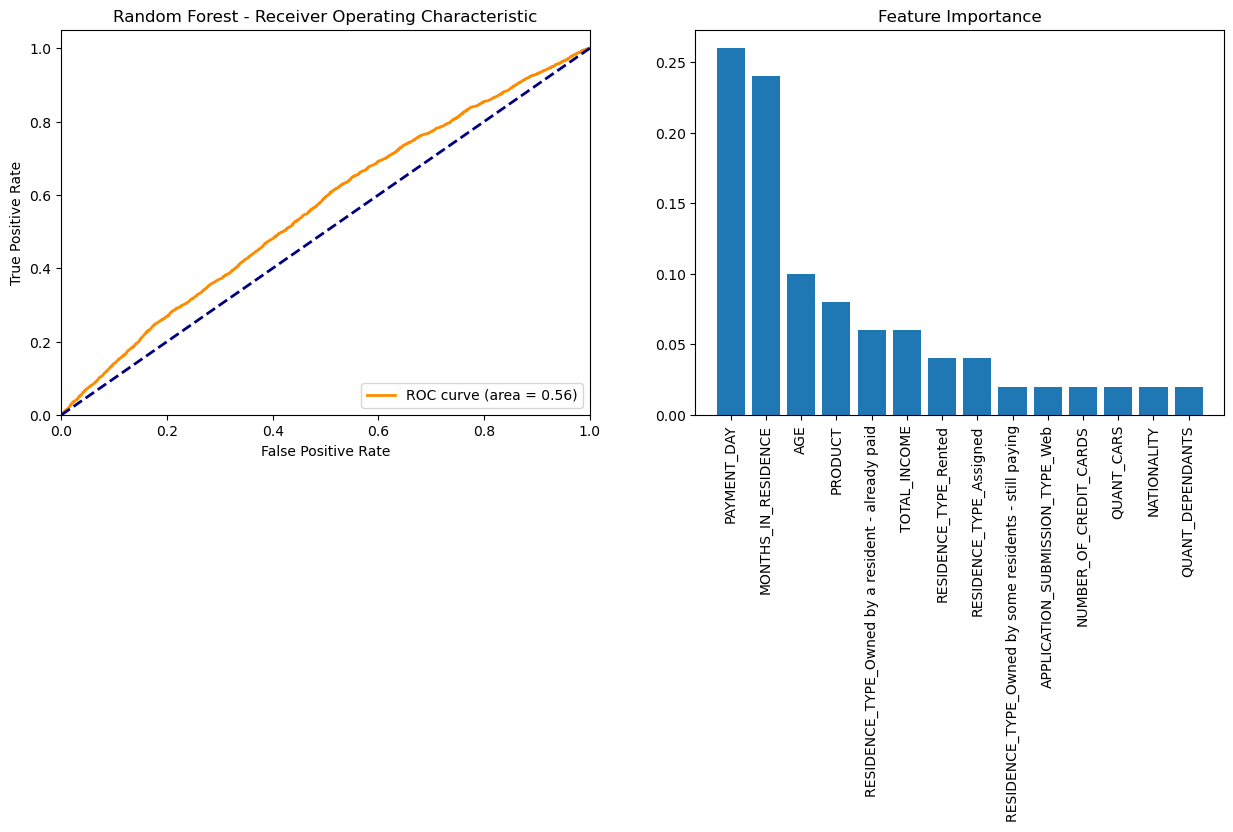

In [431]:
# generate data for ROC

adaboost_smote_probabilities = boosting.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, adaboost_smote_probabilities)
roc_auc = auc(fpr, tpr)
adaboost_smote_y_test = y_test
# generate data for Feature Importance
importances = boosting.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 5))  
# Plotting ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic')
plt.legend(loc="lower right")

# plot feature importance
plt.subplot(1, 2, 2)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
# plt.tight_layout()
# fig.subplots_adjust()
plt.show()

#### SMOTEENN

In [465]:
encoded_df = pd.get_dummies(df, columns=['APPLICATION_SUBMISSION_TYPE','RESIDENCE_TYPE'], drop_first=True)
X = encoded_df.drop(['TARGET_LABEL_BAD.1','ID_CLIENT'],axis=1)
y = encoded_df['TARGET_LABEL_BAD.1']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train)
boosting = AdaBoostClassifier(random_state=42)

boosting.fit(X_resampled, y_resampled)
prediction = boosting.predict(X_test)
adaboost_smoteenn_pred = prediction
print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print(classification_report(y_test, prediction))
print('confusion_matrix:\n',confusion_matrix(y_test, prediction))
# 30/46/36/58

Accuracy: 0.5162691254092336
AUC: 0.5487975536532201
              precision    recall  f1-score   support

           0       0.78      0.48      0.60     11063
           1       0.30      0.62      0.40      3904

    accuracy                           0.52     14967
   macro avg       0.54      0.55      0.50     14967
weighted avg       0.65      0.52      0.54     14967

confusion_matrix:
 [[5319 5744]
 [1496 2408]]


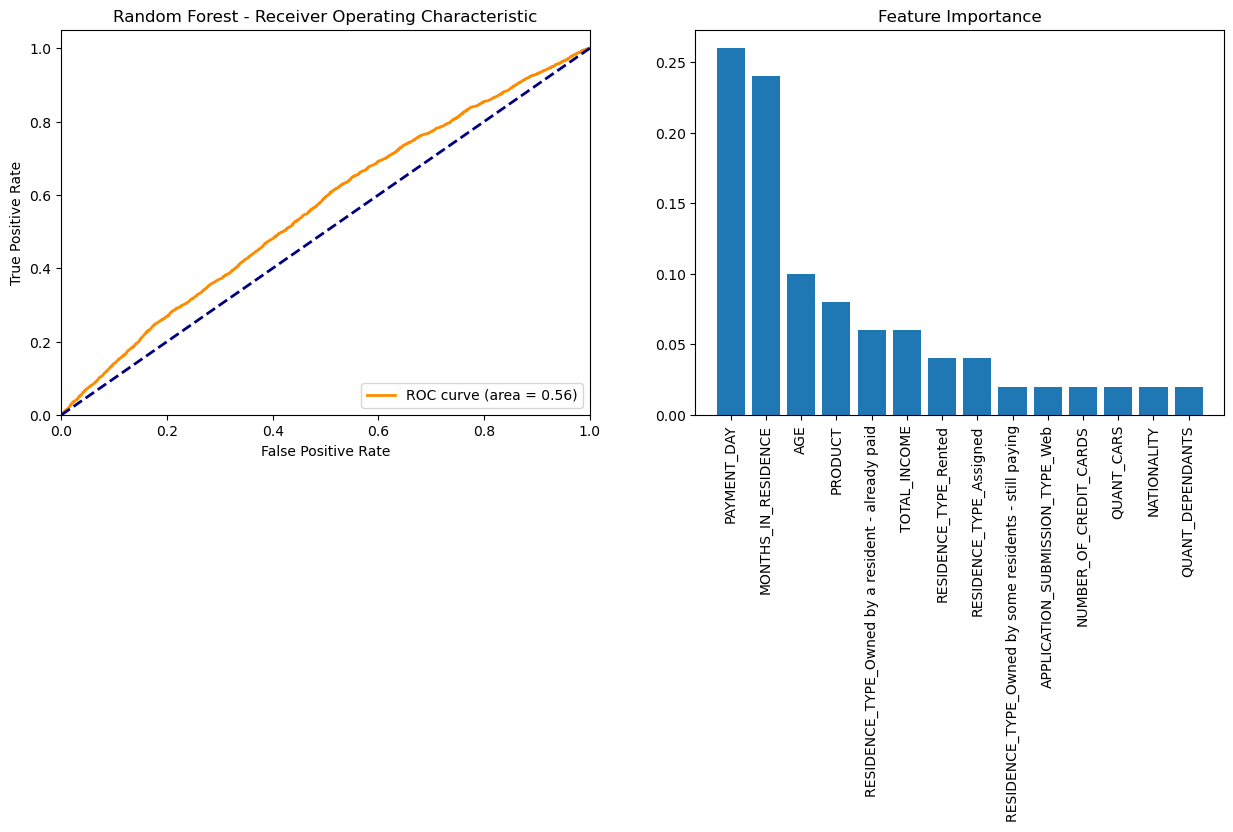

In [466]:
# generate data for ROC
adaboost_smoteenn_probabilities = boosting.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, adaboost_smoteenn_probabilities)
roc_auc = auc(fpr, tpr)
adaboost_smoteenn_y_test = y_test
# generate data for Feature Importance
importances = boosting.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 5))  
# Plotting ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic')
plt.legend(loc="lower right")

# plot feature importance
plt.subplot(1, 2, 2)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.savefig('adaboost_smoteenn_feature.png', bbox_inches = 'tight')
plt.show()


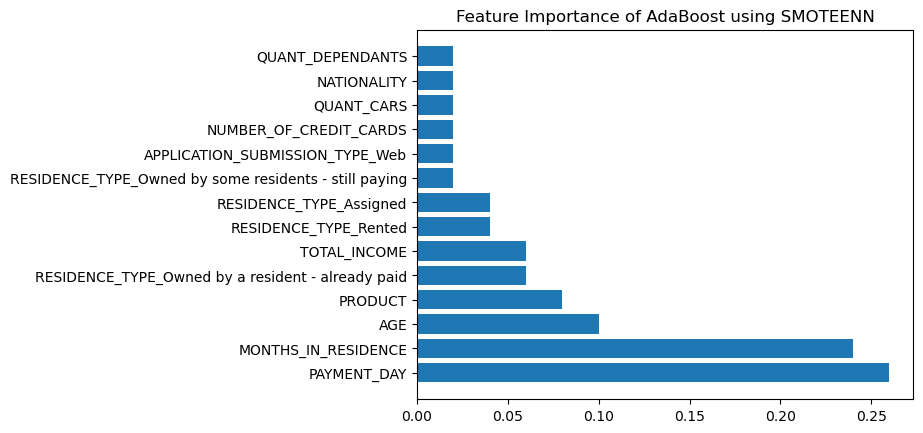

In [467]:
importances = boosting.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance of AdaBoost using SMOTEENN')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[indices], rotation=0)
# plt.xlim([-1, X_train.shape[1]])
# plt.xlim([xmin,xmax])
plt.savefig('adaboost_smoteenn_feature.png', bbox_inches = 'tight')
plt.show()


### XGBoost

#### SMOTE

In [348]:
!pip install xgboost

In [458]:
encoded_df = pd.get_dummies(df, columns=['APPLICATION_SUBMISSION_TYPE','RESIDENCE_TYPE'], drop_first=True)
X = encoded_df.drop(['TARGET_LABEL_BAD.1','ID_CLIENT'],axis=1)
y = encoded_df['TARGET_LABEL_BAD.1']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

import xgboost as xgb
from xgboost import XGBClassifier 
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

boosting = XGBClassifier(random_state=42)
boosting.fit(X_resampled, y_resampled)
prediction = boosting.predict(X_test)
xgboost_smote_pred = prediction
print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print(classification_report(y_test, prediction))
print('confusion_matrix:\n',confusion_matrix(y_test, prediction))

Accuracy: 0.6932585020378166
AUC: 0.5148650084167725
              precision    recall  f1-score   support

           0       0.75      0.89      0.81     11063
           1       0.31      0.14      0.19      3904

    accuracy                           0.69     14967
   macro avg       0.53      0.51      0.50     14967
weighted avg       0.63      0.69      0.65     14967

confusion_matrix:
 [[9822 1241]
 [3350  554]]


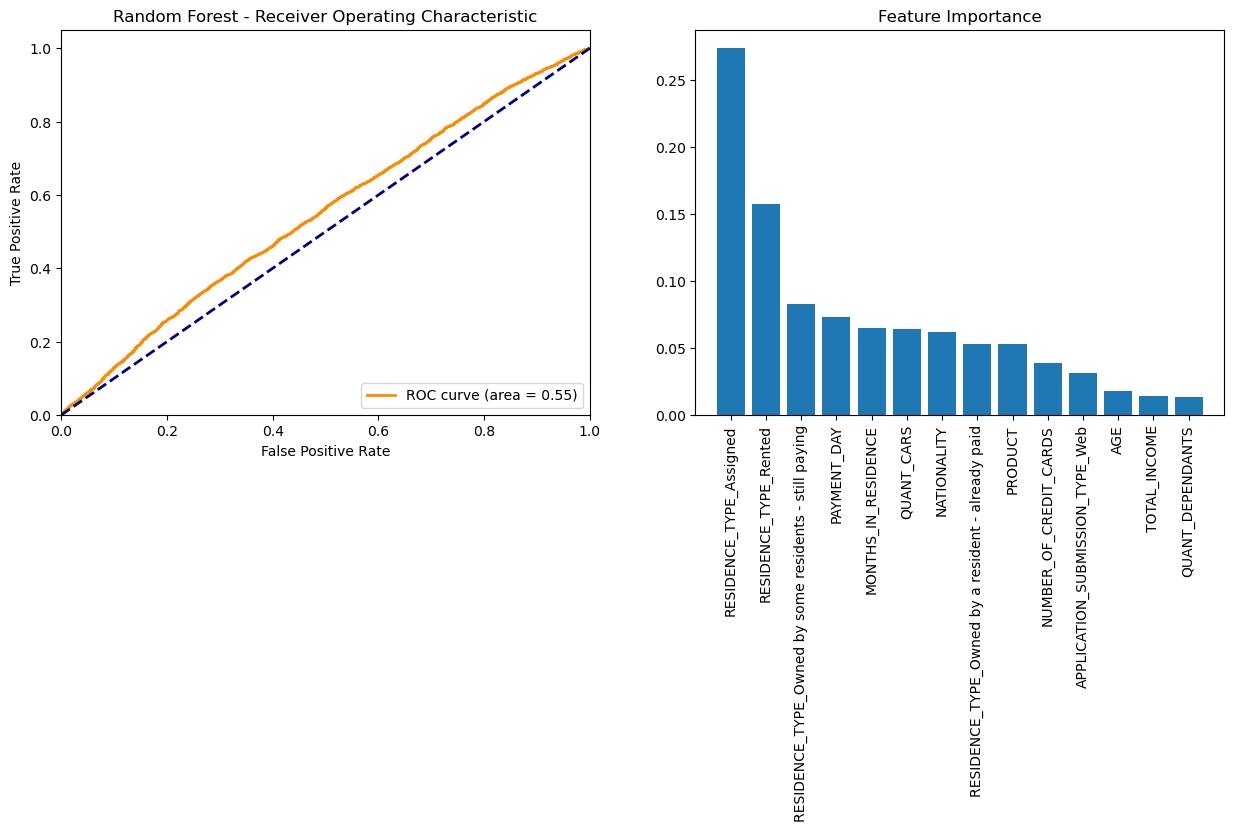

In [459]:
# generate data for ROC
xgboost_smote_probabilities = boosting.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, xgboost_smote_probabilities)
roc_auc = auc(fpr, tpr)
xgboost_smote_y_test = y_test
# generate data for Feature Importance
importances = boosting.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 5))  
# Plotting ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic')
plt.legend(loc="lower right")

# plot feature importance
plt.subplot(1, 2, 2)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

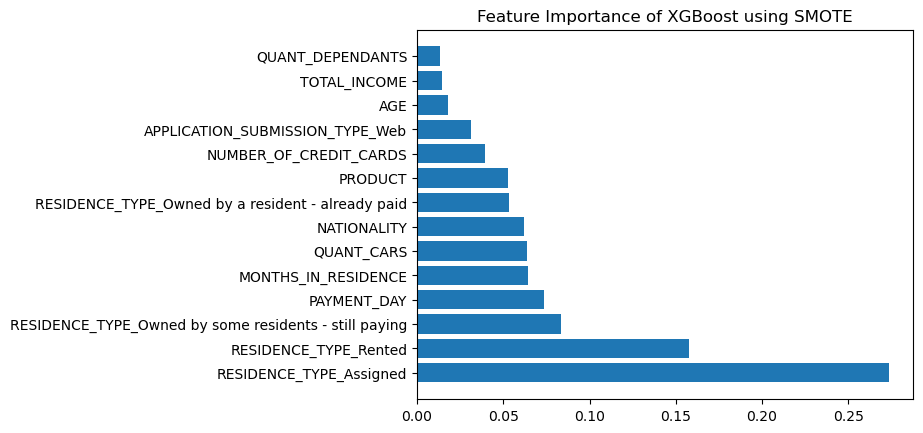

In [461]:
importances = boosting.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance of XGBoost using SMOTE')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[indices], rotation=0)
# plt.xlim([-1, X_train.shape[1]])
# plt.xlim([xmin,xmax])
plt.savefig('xgboost_smote_feature.png', bbox_inches = 'tight')
plt.show()


Back to [ToC](#Table-of-Contents)

#### SMOTEENN

In [403]:
encoded_df = pd.get_dummies(df, columns=['APPLICATION_SUBMISSION_TYPE','RESIDENCE_TYPE'], drop_first=True)
X = encoded_df.drop(['TARGET_LABEL_BAD.1','ID_CLIENT'],axis=1)
y = encoded_df['TARGET_LABEL_BAD.1']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

import xgboost as xgb
from xgboost import XGBClassifier 
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train)
xgboost_smoteenn_y_test = y_test
boosting = XGBClassifier(random_state=42)
boosting.fit(X_resampled, y_resampled)
prediction = boosting.predict(X_test)
xgboost_smoteenn_pred = prediction
print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print(classification_report(y_test, prediction))
print('confusion_matrix:\n',confusion_matrix(y_test, prediction))

Accuracy: 0.580076167568651
AUC: 0.5386688436236281
              precision    recall  f1-score   support

           0       0.76      0.63      0.69     11063
           1       0.30      0.45      0.36      3904

    accuracy                           0.58     14967
   macro avg       0.53      0.54      0.52     14967
weighted avg       0.64      0.58      0.60     14967

confusion_matrix:
 [[6917 4146]
 [2139 1765]]


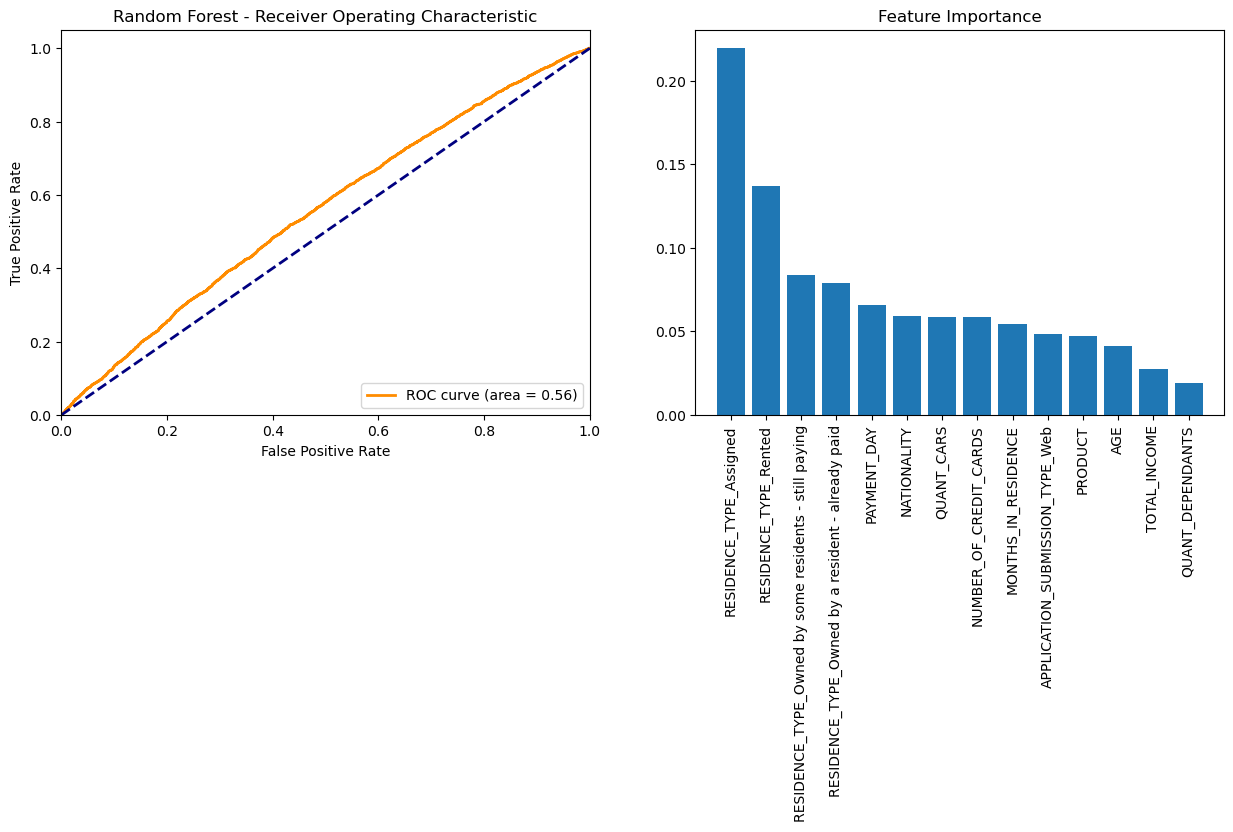

In [404]:
# generate data for ROC
xgboost_smoteenn_probabilities = boosting.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, xgboost_smoteenn_probabilities)
roc_auc = auc(fpr, tpr)
xgboost_smoteenn_y_test = y_test
# generate data for Feature Importance
importances = boosting.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 5))  
# Plotting ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic')
plt.legend(loc="lower right")

# plot feature importance
plt.subplot(1, 2, 2)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Back to [ToC](#Table-of-Contents)

### Visualization

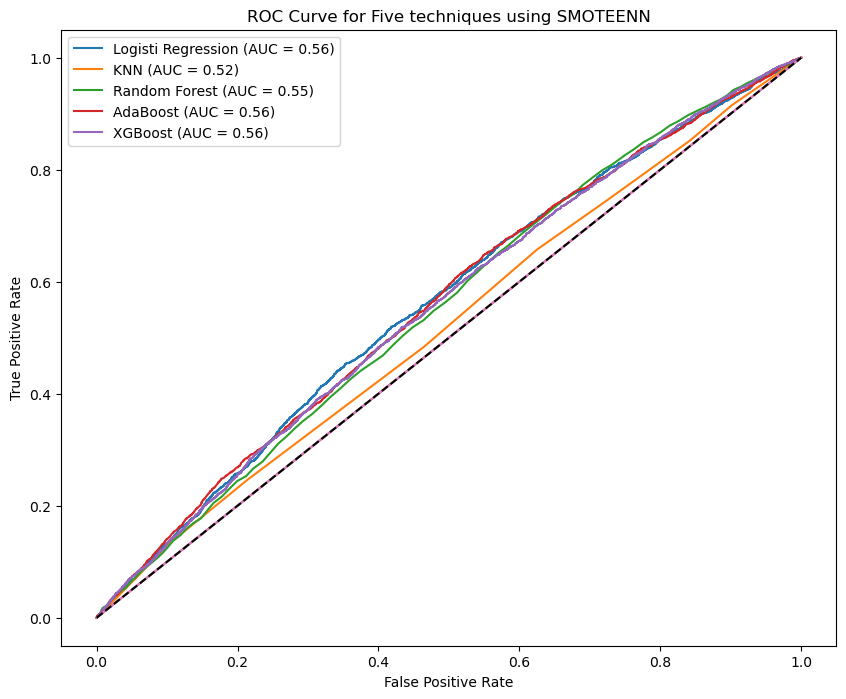

In [405]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

encoded_df = pd.get_dummies(df, columns=['APPLICATION_SUBMISSION_TYPE','RESIDENCE_TYPE'], drop_first=True)
X = encoded_df.drop(['TARGET_LABEL_BAD.1','ID_CLIENT'],axis=1)
y = encoded_df['TARGET_LABEL_BAD.1']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


fpr1, tpr1, _ = roc_curve(lr_stomeenn_y_test, lr_smoteenn_probabilities)
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(knn_smoteenn_y_test, knn_smoteenn_probabilities)
auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(rf_smoteenn_y_test, rf_smoteenn_probabilities)
auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(adaboost_smoteenn_y_test, adaboost_smoteenn_probabilities)
auc4 = auc(fpr4, tpr4)

fpr5, tpr5, _ = roc_curve(xgboost_smoteenn_y_test, xgboost_smoteenn_probabilities)
auc5 = auc(fpr5, tpr5)


plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label='Logisti Regression (AUC = {:.2f})'.format(auc1))
plt.plot(fpr2, tpr2, label='KNN (AUC = {:.2f})'.format(auc2))
plt.plot(fpr3, tpr3, label='Random Forest (AUC = {:.2f})'.format(auc3))
plt.plot(fpr4, tpr4, label='AdaBoost (AUC = {:.2f})'.format(auc4))
plt.plot(fpr5, tpr5, label='XGBoost (AUC = {:.2f})'.format(auc5))

plt.plot([0, 1], [0, 1],[0, 1], [0, 1],[0, 1], 'k--')  # 对角线

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Five techniques using SMOTEENN')
plt.legend(loc='best')

plt.savefig('ROC with SMOTEENN.png')
plt.show()

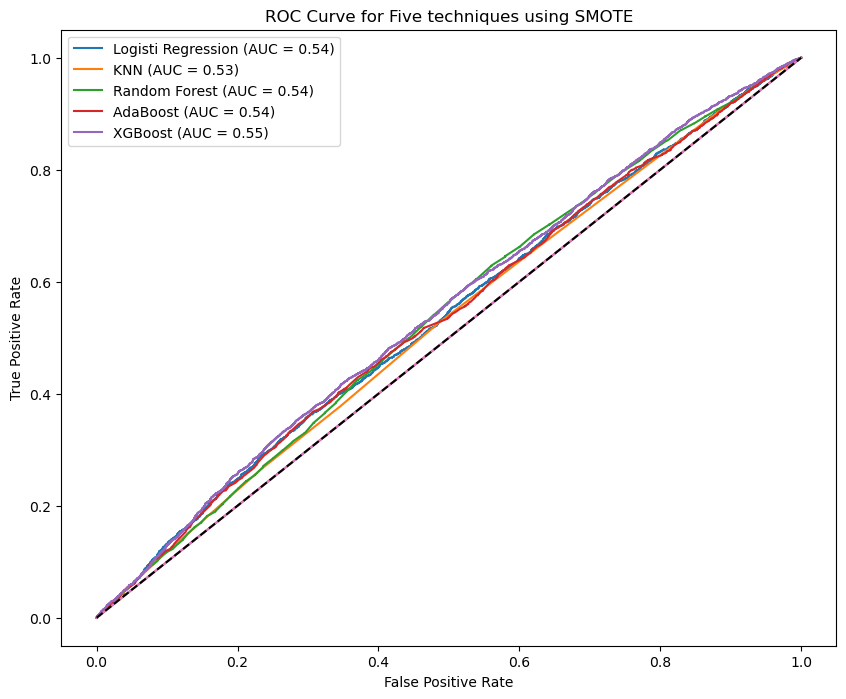

In [354]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

encoded_df = pd.get_dummies(df, columns=['APPLICATION_SUBMISSION_TYPE','RESIDENCE_TYPE'], drop_first=True)
X = encoded_df.drop(['TARGET_LABEL_BAD.1','ID_CLIENT'],axis=1)
y = encoded_df['TARGET_LABEL_BAD.1']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



fpr1, tpr1, _ = roc_curve(lr_y_test, lr_smote_probabilities)
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(knn_y_test, knn_smote_probabilities)
auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(rf_y_test, rf_smote_probabilities)
auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(adaboost_y_test, adaboost_smote_probabilities)
auc4 = auc(fpr4, tpr4)

fpr5, tpr5, _ = roc_curve(xgboost_y_test, xgboost_smote_probabilities)
auc5 = auc(fpr5, tpr5)


plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label='Logisti Regression (AUC = {:.2f})'.format(auc1))
plt.plot(fpr2, tpr2, label='KNN (AUC = {:.2f})'.format(auc2))
plt.plot(fpr3, tpr3, label='Random Forest (AUC = {:.2f})'.format(auc3))
plt.plot(fpr4, tpr4, label='AdaBoost (AUC = {:.2f})'.format(auc4))
plt.plot(fpr5, tpr5, label='XGBoost (AUC = {:.2f})'.format(auc5))

plt.plot([0, 1], [0, 1],[0, 1], [0, 1],[0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Five techniques using SMOTE')
plt.legend(loc='best')

plt.savefig('ROC with SMOTE.png')
plt.show()

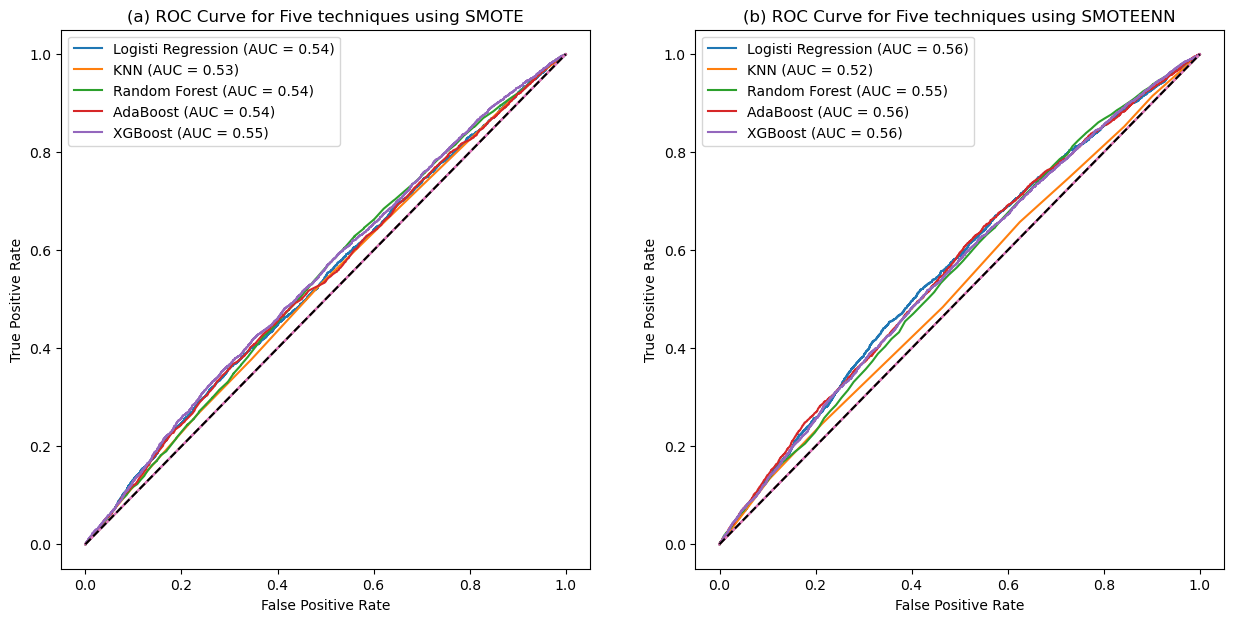

In [355]:
plt.figure(figsize=(15, 7))  
# Plotting ROC curve
plt.subplot(1, 2, 2)
fpr1, tpr1, _ = roc_curve(lr_smoteen_y_test, lr_smoteenn_probabilities)
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(knn_smoteenn_y_test, knn_smoteenn_probabilities)
auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(rf_smoteenn_y_test, rf_smoteenn_probabilities)
auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(adaboost_smoteenn_y_test, adaboost_smoteenn_probabilities)
auc4 = auc(fpr4, tpr4)

fpr5, tpr5, _ = roc_curve(xgboost_smoteenn_y_test, xgboost_smoteenn_probabilities)
auc5 = auc(fpr5, tpr5)

plt.plot(fpr1, tpr1, label='Logisti Regression (AUC = {:.2f})'.format(auc1))
plt.plot(fpr2, tpr2, label='KNN (AUC = {:.2f})'.format(auc2))
plt.plot(fpr3, tpr3, label='Random Forest (AUC = {:.2f})'.format(auc3))
plt.plot(fpr4, tpr4, label='AdaBoost (AUC = {:.2f})'.format(auc4))
plt.plot(fpr5, tpr5, label='XGBoost (AUC = {:.2f})'.format(auc5))

plt.plot([0, 1], [0, 1],[0, 1], [0, 1],[0, 1], 'k--') 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(b) ROC Curve for Five techniques using SMOTEENN')
plt.legend(loc='best')

plt.subplot(1, 2, 1)

fpr1, tpr1, _ = roc_curve(lr_y_test, lr_smote_probabilities)
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(knn_y_test, knn_smote_probabilities)
auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(rf_y_test, rf_smote_probabilities)
auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(adaboost_y_test, adaboost_smote_probabilities)
auc4 = auc(fpr4, tpr4)

fpr5, tpr5, _ = roc_curve(xgboost_y_test, xgboost_smote_probabilities)
auc5 = auc(fpr5, tpr5)
plt.plot(fpr1, tpr1, label='Logisti Regression (AUC = {:.2f})'.format(auc1))
plt.plot(fpr2, tpr2, label='KNN (AUC = {:.2f})'.format(auc2))
plt.plot(fpr3, tpr3, label='Random Forest (AUC = {:.2f})'.format(auc3))
plt.plot(fpr4, tpr4, label='AdaBoost (AUC = {:.2f})'.format(auc4))
plt.plot(fpr5, tpr5, label='XGBoost (AUC = {:.2f})'.format(auc5))

plt.plot([0, 1], [0, 1],[0, 1], [0, 1],[0, 1], 'k--')  # 对角线

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(a) ROC Curve for Five techniques using SMOTE')
plt.legend(loc='best')

plt.savefig('combine_ROC.png')
plt.show()

Back to [ToC](#Table-of-Contents)

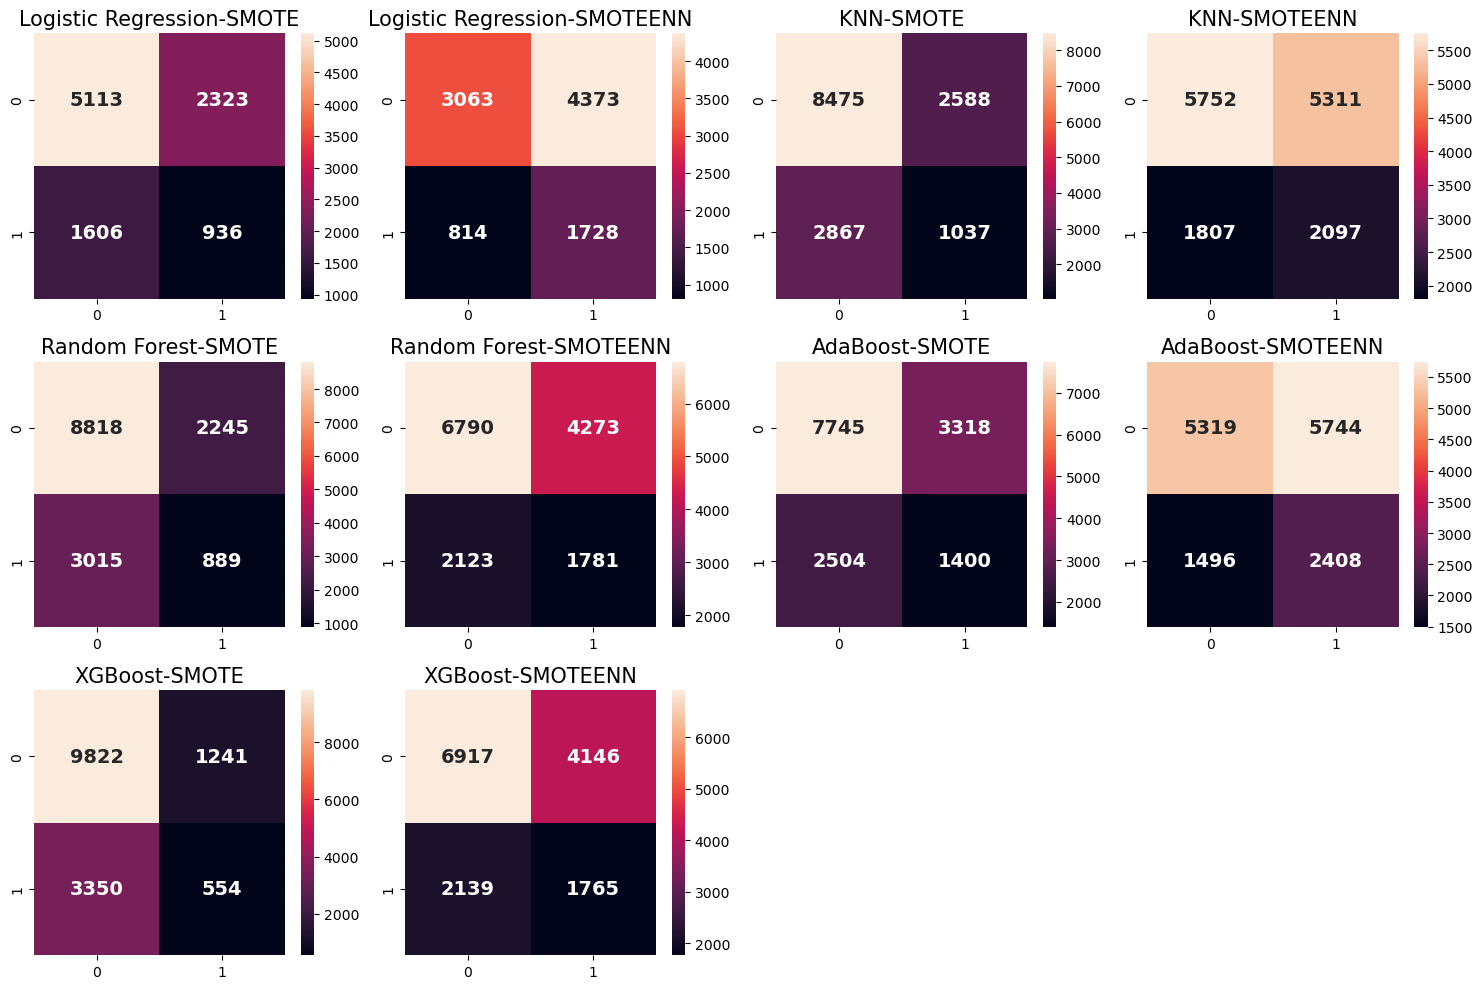

In [457]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


predictions = [lr_smote_pred, lr_smoteenn_pred,knn_smote_pred, knn_smoteenn_pred,
               rf_smote_pred, rf_smoteenn_pred,adaboost_smote_pred, adaboost_smoteenn_pred,
               xgboost_smote_pred, xgboost_smoteenn_pred]
true_labels = [lr_smote_y_test,lr_smoteenn_y_test,knn_smote_y_test,knn_smoteenn_y_test,
              rf_smote_y_test,rf_smoteenn_y_test,adaboost_smote_y_test,adaboost_smoteenn_y_test,
              xgboost_smote_y_test,xgboost_smoteenn_y_test]


fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
title = ['Logistic Regression-SMOTE','Logistic Regression-SMOTEENN',
         'KNN-SMOTE','KNN-SMOTEENN',
         'Random Forest-SMOTE','Random Forest-SMOTEENN',
         'AdaBoost-SMOTE','AdaBoost-SMOTEENN',
         'XGBoost-SMOTE','XGBoost-SMOTEENN',
        ]
# Iterate over pairs of predictions and true labels
for i, (model_predictions, model_true_labels) in enumerate(zip(predictions, true_labels)):
    # Compute confusion matrix for each model
    cm = confusion_matrix(model_true_labels, model_predictions)
    
    # Find the correct subplot row and column
    row = i // 4
    col = i % 4
    
    # Plot the confusion matrix in the correct subplot
    sns.heatmap(cm, annot=True, ax=axes[row, col], fmt='g',annot_kws={'size':14,'weight':'bold'})
    axes[row, col].set_title(title[i], fontsize = 15)
    

for j in range(10,12):
    fig.delaxes(axes[j // 4, j % 4])
plt.tight_layout()
plt.savefig('confusion matrix.png')
plt.show()

